In [2]:
import sys
import numpy as np
import scipy as sp
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import keras
from tqdm import tqdm
from sklearn.cross_validation import train_test_split
%matplotlib inline

In [4]:
data = pd.read_csv('sample/data.csv')

In [5]:
grouped = data.groupby('id')
sequences = [group[['date', 'sum']].values for name, group in grouped]

In [6]:
dataSequences = sequences

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D
from keras.layers import Embedding, InputLayer
from keras.layers import LSTM

In [15]:
np.nonzero([1, 0, 2, 3, 0, 0, 5])[0]

array([0, 2, 3, 6])

In [16]:
len(dataSequences)

110000

In [17]:
class Preprocess:
    def __init__(self, sequences, maxTime=438):
        self.maxTime = maxTime
        self.data = self.makeDataMatrix(sequences)

    def makeDataMatrix(self, sequences):
        result = -np.ones((len(sequences), self.maxTime))
        for i, seq in enumerate(sequences):
            result[i, seq[:, 0] - 1] = seq[:, 1]
        return result
    
    def processWeek(self, week):
        nz = np.nonzero(1 * (week != -1.))[0]
        if nz.shape[0] > 0:
            return week[nz[0]]
        return 0
    
    def processObject(self, vec):
        result = []
        for i in np.arange(1, vec.shape[0]-6):
            result.append(self.processWeek(vec[i:i+7]))
        return np.asarray(result)
        
    def train(self):
        data = self.data[:, :-7]
        X = data[:, :-7]
        Y = np.asarray(list(tqdm(self.processObject(vec) for vec in data)))
        return X, Y
    
    def validation(self):
        data = self.data[:, 7:]
        X = data[:, :-7]
        Y = np.asarray(list(tqdm(self.processObject(vec) for vec in data)))
        return X, Y
    
    def test(self):
        return self.data[:, 14:]

In [18]:
preproc = Preprocess(dataSequences)

In [19]:
trainX, trainY = preproc.train()

110000it [08:54, 205.98it/s]


In [94]:
validationX, validationY = preproc.validation()

110000it [05:44, 319.71it/s]


In [100]:
testX = preproc.test()

In [32]:
preproc.data.shape

(110000, 438)

In [35]:
trainX.shape

(110000, 424)

In [38]:
def onehot(Y):
    result = np.zeros((Y.shape[0], Y.shape[1], 17))
    for i, yvec in tqdm(enumerate(Y)):
        for j, y in enumerate(yvec):
            result[i, j, int(y)] = 1.
    return result

In [78]:
import pickle
with open('train.dump', 'wb') as f:
    pickle.dump((trainX, trainY), f)

In [95]:
import pickle
with open('validation.dump', 'wb') as f:
    pickle.dump((validationX, validationY), f)

In [36]:
import theano
import theano.tensor as T

epsilon = 1.0e-9
def custom_objective(y_true, y_pred):
    y_true = y_true[-1]
    y_pred = y_pred[-1]
    '''Just another crossentropy'''
    y_pred = T.clip(y_pred, epsilon, 1.0 - epsilon)
    y_pred /= y_pred.sum(axis=-1, keepdims=True)
    cce = T.nnet.categorical_crossentropy(y_pred, y_true)
    return cce

ModuleNotFoundError: No module named 'theano'

In [39]:
ohTrainY = onehot(trainY)

110000it [00:28, 3833.61it/s]


In [42]:
# as the first layer in a Sequential model

model = Sequential()
model.add(LSTM(256, input_shape=(438-14, 1), return_sequences=True))
model.add(TimeDistributed(Dense(128, activation='tanh')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Dense(17, activation='softmax')))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
objects = 10
lenghth = 20
features = 30
classes = 14

model = Sequential()
model.add(LSTM(256, input_shape=(length, features), return_sequences=True))
model.add(TimeDistributed(Dense(128, activation='tanh')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Dense(classes)))

model.compile(loss='mean_absolute_error', optimizer='adam')

In [40]:
trainX.shape, ohTrainY.shape

((110000, 424), (110000, 424, 17))

In [43]:
model.fit(trainX.reshape((-1, 438-14, 1)), ohTrainY, batch_size=8, verbose=1, nb_epoch=1)

/home/eugen/anaconda3/lib/python3.6/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
   408/110000 [..............................] - ETA: 10665s - loss: 2.2340 - acc: 0.1873

KeyboardInterrupt: 

In [220]:
model.save('epoch1.h5')

In [221]:
model.fit(trainX.reshape((-1, 438-14, 1)), ohTrainY, batch_size=8, verbose=1, nb_epoch=1)

Epoch 1/1
110000/110000 [==============================] - 9038s - loss: 1.7594 - acc: 0.3234  


In [222]:
model.save('epoch2.h5')

In [223]:
model.fit(trainX.reshape((-1, 438-14, 1)), ohTrainY, batch_size=16, verbose=1, nb_epoch=1)

Epoch 1/1
110000/110000 [==============================] - 4505s - loss: 1.7516 - acc: 0.3263  


In [224]:
model.save('epoch3.h5')

In [225]:
model.fit(trainX.reshape((-1, 438-14, 1)), ohTrainY, batch_size=32, verbose=1, nb_epoch=1)

Epoch 1/1
 44544/110000 [===========>..................] - ETA: 1345s - loss: 1.7496 - acc: 0.3270

KeyboardInterrupt: 

In [ ]:
model.save('epoch4.h5')

In [ ]:
model.fit(trainX.reshape((-1, 438-14, 1)), trainY != 0., batch_size=256, class_weight={0:1, 1:1})

In [ ]:
Xfinal = preproc.makeAbsenceFinal()

In [ ]:
Xfinal.shape

In [230]:
result = model.predict(testX.reshape((-1, 438-14, 1)), batch_size=512, verbose=1)

110000/110000 [==============================] - 55s    


In [226]:
valres = model.predict(validationX.reshape((-1, 438-14, 1)), batch_size=256, verbose=1)

110000/110000 [==============================] - 76s    


In [227]:
valcls = np.argmax(valres, axis=-1)
valcls[:, -1]

array([1, 4, 0, ..., 3, 5, 6])

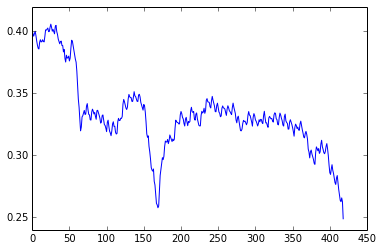

In [228]:
plt.plot([np.mean(validationY[:, -i] == valcls[:, -i]) for i in range(1, 420)])

In [229]:
np.mean(validationY[:, -1] == valcls[:, -1])

0.40065454545454543

In [231]:
list(enumerate(np.argmax(result[:, -1, :], axis=-1)[:100]))

[(0, 1),
 (1, 4),
 (2, 0),
 (3, 6),
 (4, 1),
 (5, 4),
 (6, 1),
 (7, 5),
 (8, 4),
 (9, 0),
 (10, 4),
 (11, 6),
 (12, 5),
 (13, 0),
 (14, 5),
 (15, 4),
 (16, 0),
 (17, 6),
 (18, 3),
 (19, 2),
 (20, 0),
 (21, 3),
 (22, 0),
 (23, 5),
 (24, 4),
 (25, 0),
 (26, 1),
 (27, 5),
 (28, 3),
 (29, 3),
 (30, 5),
 (31, 0),
 (32, 6),
 (33, 5),
 (34, 0),
 (35, 0),
 (36, 2),
 (37, 2),
 (38, 0),
 (39, 0),
 (40, 5),
 (41, 0),
 (42, 0),
 (43, 5),
 (44, 5),
 (45, 5),
 (46, 6),
 (47, 4),
 (48, 2),
 (49, 0),
 (50, 5),
 (51, 0),
 (52, 0),
 (53, 0),
 (54, 6),
 (55, 4),
 (56, 6),
 (57, 0),
 (58, 5),
 (59, 6),
 (60, 4),
 (61, 1),
 (62, 0),
 (63, 0),
 (64, 6),
 (65, 4),
 (66, 3),
 (67, 5),
 (68, 0),
 (69, 0),
 (70, 3),
 (71, 0),
 (72, 1),
 (73, 0),
 (74, 1),
 (75, 6),
 (76, 3),
 (77, 6),
 (78, 5),
 (79, 6),
 (80, 0),
 (81, 6),
 (82, 3),
 (83, 0),
 (84, 6),
 (85, 0),
 (86, 5),
 (87, 2),
 (88, 0),
 (89, 6),
 (90, 0),
 (91, 2),
 (92, 0),
 (93, 5),
 (94, 2),
 (95, 4),
 (96, 6),
 (97, 4),
 (98, 5),
 (99, 6)]

In [ ]:
list(enumerate(np.argmax(result, axis=1)[:100]))

In [ ]:
np.percentile(result, 10)

In [ ]:
np.sum(result > 0.60) * 1. / len(result)

In [ ]:
plt.hist(result, bins=50)

In [ ]:
result[13]

In [96]:
ohValicY = onehot(validationY)

110000it [00:15, 6988.73it/s]


In [98]:
score = model.evaluate(validationX.reshape((-1, 438-14, 1)), ohValicY, batch_size=512)

110000/110000 [==============================] - 43s    


In [99]:
score

[1.3764960302526301, 0.55571668732383039]

In [ ]:
idx = 0
plt.plot(sequences[0][:, 0], np.cumsum(sequences[0][:, 1]))

In [234]:
import csv
with open('submission.csv', 'wb') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'sum'])
    for id, res in enumerate(result[:, -1, :]):
        writer.writerow([id+1, np.argmax(res)])

In [237]:
!cat submission.csv | head -n 10











cat: write error: Broken pipe
